In [1]:
# SETUP & IMPORTS

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

print(torch.__version__)


2.1.0+cu121


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# DEFINE & CREATE DATASET

class CreditcardDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file, sep=",")

        self.df = self.df.drop('Time', axis=1)

        y = self.df.iloc[:]['Class'].values
        x = self.df.drop('Class', axis=1).values

        self.X = torch.tensor(x, dtype=torch.float32)
        self.Y = torch.tensor(y)

        self.transform = transform

        print(self.df.iloc[:]['Class'].value_counts())

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] #sample


CC_dataset = CreditcardDataset(csv_file='/content/drive/MyDrive/AI4CySec/practicas/P1/creditcard.csv')


0    284315
1       492
Name: Class, dtype: int64


In [ ]:
# PREPARE DATASETS
# Opción 1 para CREACIÓN DE DATASET
# Split basado en indices

batch_size = 2048
val_split = .1  # 10%
test_split = .1 # 10%
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(CC_dataset)
#print ("total: ", dataset_size)
indices = list(range(dataset_size))
split1 = int(np.floor(val_split * dataset_size))
#print("s1 ", split1)
split2 = int(np.floor(test_split * dataset_size))
#print("s2 ", split2)

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[split1+split2:], indices[:split1], indices[split1:split1+split2]
"""
print ("ti: ", len(train_indices))
print ("vi: ", len(val_indices))
print ("ti: ", len(test_indices))
"""
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(CC_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=train_sampler)
val_loader = DataLoader(CC_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=val_sampler)
test_loader = DataLoader(CC_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=test_sampler)

print ("# total samples:", len(CC_dataset))
print ("# total TRAIN samples:", len(train_loader.sampler))
print ("# total VAL samples:", len(val_loader.sampler))
print ("# total TEST samples:", len(test_loader.sampler))

# Show on iteration from train dataset
# iter() calls the __iter__() method on the loader which returns an iterator.
# next() then calls the __next__() method on that iterator to get the first iteration.
# Running next() again will get the second item of the iterator, etc.

dataiter = iter(train_loader)

X, Y = next(dataiter)
print ('data from one iteration:', X)
print ('labels from one iteration:', Y)


# total samples: 284807
# total TRAIN samples: 227847
# total VAL samples: 28480
# total TEST samples: 28480
data from one iteration: tensor([[ 4.2222e-02,  5.5754e-01,  6.2558e-01,  ..., -3.7929e-02,
         -5.5498e-02,  6.2800e+00],
        [ 1.1798e+00,  6.1891e-01, -2.5671e-01,  ...,  2.6159e-02,
          4.7566e-02,  1.0000e+00],
        [-9.3096e-01,  3.5885e-01,  1.6899e+00,  ..., -2.2819e-01,
         -1.6991e-01,  3.0140e+01],
        ...,
        [-7.5080e-01,  3.7548e-02,  1.7330e+00,  ...,  1.7267e-02,
          3.5335e-02,  8.9160e+01],
        [-8.4045e-02,  1.2272e+00, -1.3348e-01,  ...,  2.2498e-01,
          2.2597e-01,  3.7400e+00],
        [-1.0254e+00,  3.7348e-01,  9.7681e-01,  ...,  2.0214e-01,
          1.2403e-01,  2.3990e+01]])
labels from one iteration: tensor([0, 0, 0,  ..., 0, 0, 0])


In [ ]:
# PREPARE DATASETS
# Opción 2 para CREACIÓN DE DATASET
# Split basado en random_split
# Dataset NO balanceado

batch_size = 2048
train_split = 0.8 # 80%
val_split = 0.5 # 50% del resto

train_size = int(train_split * len(CC_dataset))
val_size = int(val_split * (len(CC_dataset) - train_size))
test_size = len(CC_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CC_dataset, [train_size, val_size, test_size])
#print (len(CC_dataset))
#print (len(train_dataset))
#print (len(val_dataset))
#print (len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            #sampler=train_sampler
                            )
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            #sampler=val_sampler
                            )
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            #sampler=test_sampler
                            )

print ("# total samples:", len(CC_dataset))
print ("# total TRAIN samples:", len(train_loader.sampler))
print ("# total VAL samples:", len(val_loader.sampler))
print ("# total TEST samples:", len(test_loader.sampler))

# Show on iteration from train dataset
# iter() calls the __iter__() method on the loader which returns an iterator.
# next() then calls the __next__() method on that iterator to get the first iteration.
# Running next() again will get the second item of the iterator, etc.

dataiter = iter(train_loader)

X, Y = next(dataiter)
print ('data from one iteration:', X)
print ('labels from one iteration:', Y)


# total samples: 284807
# total TRAIN samples: 227845
# total VAL samples: 28481
# total TEST samples: 28481
data from one iteration: tensor([[ 1.4496e+00, -1.0476e+00,  4.0733e-01,  ...,  2.4432e-02,
          2.7679e-02,  5.0000e+01],
        [ 1.8119e+00, -3.3360e-01, -1.8601e+00,  ..., -3.0182e-02,
         -1.8241e-02,  1.0211e+02],
        [ 1.3467e+00, -1.4838e+00,  6.1031e-01,  ...,  3.8620e-02,
          2.7412e-02,  9.1000e+01],
        ...,
        [ 2.1168e+00, -9.7736e-01, -5.3486e-01,  ...,  8.5089e-03,
         -2.9124e-02,  3.5000e+01],
        [-9.3879e-01,  7.9384e-01, -7.7231e-01,  ..., -6.3499e-02,
          1.1358e-02,  6.1480e+01],
        [-7.2968e-01,  1.6163e+00, -1.0707e+00,  ...,  3.0932e-01,
          3.4364e-01,  1.3460e+01]])
labels from one iteration: tensor([0, 0, 0,  ..., 0, 0, 0])


In [4]:
# PREPARE DATASETS
# Opción 3 para CREACIÓN DE DATASET
# Split basado en WeightedRandomSampler
# Dataset balanceado

from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm

batch_size = 2048
train_split = 0.8 # 80%
val_split = 0.5 # 50% del resto

train_size = int(train_split * len(CC_dataset))
val_size = int(val_split * (len(CC_dataset) - train_size))
test_size = len(CC_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CC_dataset, [train_size, val_size, test_size])
#print (len(CC_dataset))
#print (len(train_dataset))
#print (len(val_dataset))
#print (len(test_dataset))


# WeightedRandomSampler for TRAIN
class_0 = 0
class_1 = 0
train_labels = []
for i in range(len(train_dataset)):
    _, Y = train_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    train_labels.append(Y)

print ('TRAIN NO_FRAUD: ', class_0)
print ('TRAIN FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = train_labels #train_dataset.Y #corresponding labels of samples
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
train_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# WeightedRandomSampler for VAL
class_0 = 0
class_1 = 0
val_labels = []
for i in range(len(val_dataset)):
    _, Y = val_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    val_labels.append(Y)

print ('VAL NO_FRAUD: ', class_0)
print ('VAL FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = val_labels
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
val_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# WeightedRandomSampler for TEST
class_0 = 0
class_1 = 0
test_labels = []
for i in range(len(test_dataset)):
    _, Y = test_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    test_labels.append(Y)

print ('TEST NO_FRAUD: ', class_0)
print ('TEST FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = test_labels #train_dataset.Y #corresponding labels of samples
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
test_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=train_sampler
                            )
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=val_sampler
                            )
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=test_sampler
                            )

print ("# total samples:", len(CC_dataset))
print ("# total TRAIN samples:", len(train_loader.sampler))
print ("# total VAL samples:", len(val_loader.sampler))
print ("# total TEST samples:", len(test_loader.sampler))

# Show on iteration from train dataset
# iter() calls the __iter__() method on the loader which returns an iterator.
# next() then calls the __next__() method on that iterator to get the first iteration.
# Running next() again will get the second item of the iterator, etc.

dataiter = iter(train_loader)

X, Y = next(dataiter)
print ('data from one iteration:', X)
print ('labels from one iteration:', Y)

"""
# From CC_dataset
0    284315
1       492
"""

TRAIN NO_FRAUD:  227439
TRAIN FRAUD:     406
VAL NO_FRAUD:  28433
VAL FRAUD:     48
TEST NO_FRAUD:  28443
TEST FRAUD:     38
# total samples: 284807
# total TRAIN samples: 227845
# total VAL samples: 28481
# total TEST samples: 28481
data from one iteration: tensor([[-3.1138e+00,  5.8586e-01, -5.3997e+00,  ...,  8.8488e-01,
         -2.5370e-01,  2.4500e+02],
        [ 2.0602e+00,  1.8599e-02, -1.0729e+00,  ..., -6.0525e-02,
         -5.8989e-02,  1.2900e+00],
        [-4.9918e+00,  5.2133e+00, -9.1113e+00,  ..., -4.0234e-01,
         -8.8289e-01,  0.0000e+00],
        ...,
        [-2.1209e+01,  1.2652e+01, -2.3554e+01,  ...,  1.5509e+00,
          4.6146e-01,  9.9990e+01],
        [-5.2681e+00,  9.0676e+00, -1.5961e+01,  ...,  1.5847e+00,
          7.2006e-01,  1.0000e+00],
        [ 2.0183e+00,  4.2180e-01, -2.4735e+00,  ..., -1.0186e-02,
         -3.8357e-02,  4.8800e+00]])
labels from one iteration: tensor([1, 0, 1,  ..., 1, 1, 0])


'\n# From CC_dataset\n0    284315\n1       492\n'

In [5]:
# ACTIVATE DEVICE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)


cuda:0


'Tesla T4'

In [6]:
# DEFINE NEURAL NETWORK MODEL

class FraudNet(nn.Module):
    def __init__(self):
        super(FraudNet, self).__init__()
        self.l1 = nn.Linear(29, 16)
        self.l2 = nn.Linear(16, 2)
        self.relu = nn.ReLU()

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)

        return out

model = FraudNet()
model.to(device)

print (model)

FraudNet(
  (l1): Linear(in_features=29, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
)


In [7]:
# DEFINE LOSS FUNCTION AND OPTIMIZATION METHOD

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# DEFINE TRAIN & EVAL FUNCTIONS

def train_model(model, train_loader, criterion, optimizer, epoch):

    model.train()

    total_epoch_loss = 0
    total_epoch_acc = 0

    for i, (X, Y) in enumerate(train_loader):
        # X from dataset: [batch, 29]
        # Y from dataset: [batch]
        #print (X.size())
        #print (Y.size())

        X, Y = X.to(device), Y.to(device)

        # Forward pass
        outputs = model(X)
        # outputs: [batch, 2] # NO_FRAUD & FRAUD
        #print (outputs.size())
        #print (outputs)
        loss = criterion(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_corrects = (torch.max(outputs, 1)[1].view(Y.size()).data == Y.data).float().sum()
        acc = 100.0 * num_corrects/len(Y)

        if (i+1) % 1000 == 0:
          print (f'Epoch: {epoch+1}, Idx: ({i+1}/{len(train_loader)}), Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_loader), total_epoch_acc/len(train_loader)


def eval_model(model, val_loader, criterion):

  model.eval()

  total_epoch_loss = 0
  total_epoch_acc = 0

  with torch.no_grad():

    for i, (X, Y) in enumerate(val_loader):
        # X from dataset: [batch, 29]
        # Y from dataset: [batch]
        #print (X.size())
        #print (Y.size())

        X, Y = X.to(device), Y.to(device)

        # Forward pass
        outputs = model(X)
        # outputs: [batch, 2] # NO_FRAUD & FRAUD
        #print (outputs.size())
        #print (outputs)
        loss = criterion(outputs, Y)

        num_corrects = (torch.max(outputs, 1)[1].view(Y.size()).data == Y.data).float().sum()
        acc = 100.0 * num_corrects/len(Y)

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_loader), total_epoch_acc/len(val_loader)


Epoch: [01/5], Train Loss: 1.456, Train Acc: 68.56%, Val. Loss: 0.306360, Val. Acc: 91.72%
Epoch: [02/5], Train Loss: 0.389, Train Acc: 83.25%, Val. Loss: 0.268480, Val. Acc: 90.53%
Epoch: [03/5], Train Loss: 0.325, Train Acc: 86.68%, Val. Loss: 0.271950, Val. Acc: 90.52%
Epoch: [04/5], Train Loss: 0.303, Train Acc: 87.21%, Val. Loss: 0.271488, Val. Acc: 90.85%
Epoch: [05/5], Train Loss: 0.288, Train Acc: 87.73%, Val. Loss: 0.300819, Val. Acc: 90.76%
Training complete in 0m 13s


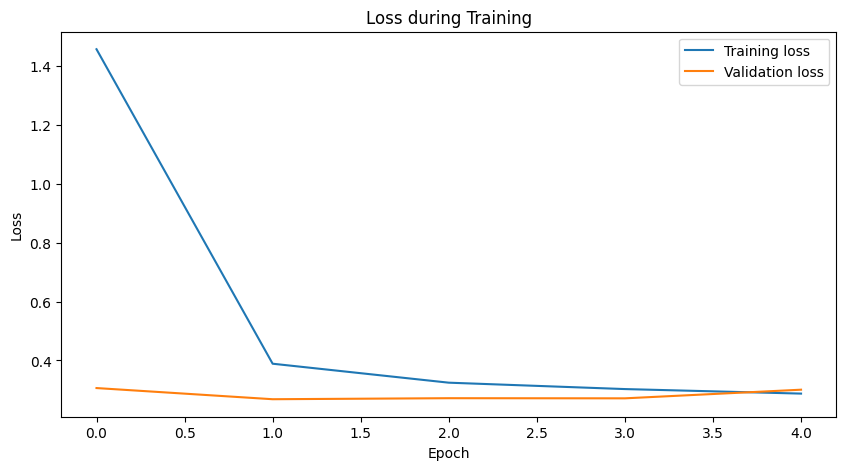

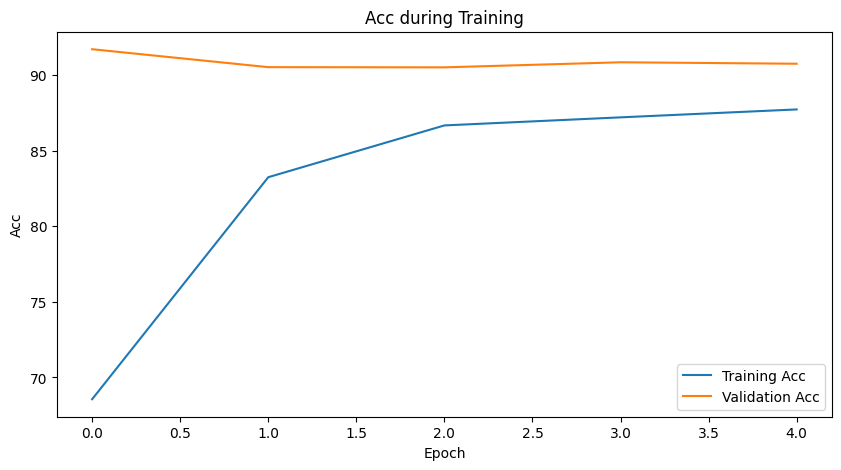

In [9]:
# TRAINING LOOP

since = time.time()

epochs = 5 #20 #5 #1 #20 #150 ##10 #200 #50 #10 #100
train_loss_epochs = []
val_loss_epochs = []
train_acc_epochs = []
val_acc_epochs = []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = eval_model(model, val_loader, criterion)

    print(f'Epoch: [{epoch+1:02}/{epochs}], Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    train_loss_epochs.append(train_loss)
    val_loss_epochs.append(val_loss)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

plt.figure(figsize=(10,5))
plt.title("Loss during Training")
plt.plot(train_loss_epochs,label="Training loss")
plt.plot(val_loss_epochs,label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Acc during Training")
plt.plot(train_acc_epochs,label="Training Acc")
plt.plot(val_acc_epochs,label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

#torch.save(model.state_dict(), './data/FraudNET.pth')

In [10]:
# TEST THE MODEL

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for X, Y in test_loader:

        X, Y = X.to(device), Y.to(device)

        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += Y.size(0)
        n_correct += (predicted == Y).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test: {acc} %')

Accuracy of the network on test: 94.22070854253712 %


Accuracy of the network on test: 93.83448614866052 %


<ipython-input-11-64328837cd02>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + listclasses, rotation=90)
<ipython-input-11-64328837cd02>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + listclasses)


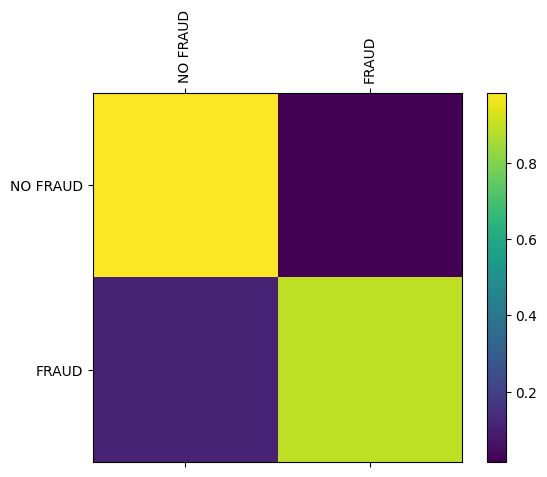

tensor([[0.9844, 0.0156],
        [0.1082, 0.8918]])


In [11]:
# CONFUSION MATRIX

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

listclasses = ['NO FRAUD', 'FRAUD']
numclasses = 2

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(numclasses, numclasses)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for X, Y in test_loader:

        X, Y = X.to(device), Y.to(device)

        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += Y.size(0)
        n_correct += (predicted == Y).sum().item()

        for i in range(len(Y)):
          label_i = Y[i]
          predicted_i = predicted[i].item()
          confusion[label_i][predicted_i] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test: {acc} %')

# Normalize by dividing every row by its sum
for i in range(numclasses):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + listclasses, rotation=90)
ax.set_yticklabels([''] + listclasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print (confusion)